In [1]:
# from https://www.kaggle.com/anokas/simple-keras-starter

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import keras.backend as K

import cv2
from tqdm import tqdm

x_train = []
y_train = []

df_train = pd.read_csv('/home/jeff/Downloads/data/amazon/train_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('/home/jeff/Downloads/data/amazon/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (32, 32)))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

print(x_train.shape)
print(y_train.shape)

split = 30000
split2 = 35000
x_train, x_valid, x_test, y_train, y_valid, y_test = (
    x_train[:split], x_train[split:split2], x_train[:split2],
    y_train[:split], y_train[split:split2], y_train[:split2])

Using TensorFlow backend.
100%|██████████| 40479/40479 [05:47<00:00, 116.46it/s]


(40479, 32, 32, 3)
(40479, 17)


In [2]:
def fbeta(y_true, y_pred):
    beta = 2
    
    tp = K.sum(K.round(y_true*y_pred))
    fp = K.sum(K.round(K.clip(y_pred-y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true-y_pred, 0, 1)))
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall)

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy', fbeta])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [4]:
early_stopping = EarlyStopping(patience=10, verbose=1)

model.fit(x_train, y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          callbacks=[early_stopping],
          validation_data=(x_valid, y_valid))

Train on 30000 samples, validate on 5000 samples
Epoch 1/100
30000/30000 [==============================] - 14s - loss: 0.2573 - acc: 0.9021 - fbeta: 0.6271 - val_loss: 0.2034 - val_acc: 0.9182 - val_fbeta: 0.6366
Epoch 2/100
30000/30000 [==============================] - 8s - loss: 0.2018 - acc: 0.9203 - fbeta: 0.6797 - val_loss: 0.1805 - val_acc: 0.9276 - val_fbeta: 0.6925
Epoch 3/100
30000/30000 [==============================] - 8s - loss: 0.1894 - acc: 0.9255 - fbeta: 0.7047 - val_loss: 0.1722 - val_acc: 0.9319 - val_fbeta: 0.7083
Epoch 4/100
30000/30000 [==============================] - 8s - loss: 0.1814 - acc: 0.9285 - fbeta: 0.7181 - val_loss: 0.1656 - val_acc: 0.9334 - val_fbeta: 0.7323
Epoch 5/100
30000/30000 [==============================] - 8s - loss: 0.1760 - acc: 0.9307 - fbeta: 0.7281 - val_loss: 0.1650 - val_acc: 0.9339 - val_fbeta: 0.7461
Epoch 6/100
30000/30000 [==============================] - 8s - loss: 0.1724 - acc: 0.9323 - fbeta: 0.7353 - val_loss: 0.1615 - va

In [5]:
model.save('/home/jeff/Downloads/data/amazon/model.h5')

In [6]:
from sklearn.metrics import fbeta_score

def optimize_f2_thresholds(y, p, verbose=True, resolution=100):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(17):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.2]*17
    for i in range(17):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            i2 /= resolution
            x[i] = i2
            score = mf(x)
            if score > best_score:
                best_i2 = i2
                best_score = score
            x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)

    return x

In [7]:
y_train_preds = model.predict(x_train)
y_valid_preds = model.predict(x_valid)

In [8]:
best_thresholds = optimize_f2_thresholds(y_valid, y_valid_preds)

0 0.14 0.877194024805
1 0.12 0.87727937947
2 0.11 0.877743546878
3 0.04 0.877756722817
4 0.09 0.878365986506
5 0.16 0.878518896231
6 0.1 0.878625935209
7 0.12 0.879436866287
8 0.09 0.879436866287
9 0.15 0.879489252579


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


10 0.22 0.879587686659
11 0.21 0.879836393227
12 0.09 0.879860878719
13 0.07 0.879987943309
14 0.22 0.880204006873
15 0.18 0.880440165133
16 0.16 0.880825499688


In [9]:
TEST_PATH = '/home/jeff/Downloads/data/amazon/test-jpg'
TEST_PATH2 = '/home/jeff/Downloads/data/amazon/test-jpg-additional'
OUTPUT_PATH = '/home/jeff/Downloads/data/amazon/predictions.csv'

x_test_orig = []
x_test_add = []

for f in tqdm(os.listdir(TEST_PATH), miniters=1000):
    img = cv2.imread('{}/{}'.format(TEST_PATH,f))
    x_test_orig.append(cv2.resize(img, (32, 32)))
for f in tqdm(os.listdir(TEST_PATH2), miniters=1000):
    img = cv2.imread('{}/{}'.format(TEST_PATH2,f)) 
    x_test_add.append(cv2.resize(img, (32, 32)))

100%|██████████| 20522/20522 [02:41<00:00, 127.14it/s]


In [10]:
x_test_orig = np.array(x_test_orig, np.float16) / 255
x_test_add = np.array(x_test_add, np.float16) / 255

orig_predictions = model.predict(x_test_orig)
add_predictions = model.predict(x_test_add)

In [11]:
def threshold_predictions(preds, thresholds):
    thresh_preds = np.zeros_like(preds)
    for i in range(preds.shape[1]):
        thresh_preds[:,i] = preds[:,i] > thresholds[i]
    return thresh_preds

In [12]:
fbeta_score(y_train, threshold_predictions(y_train_preds, best_thresholds), beta=2, average='samples')

0.91599796457901317

In [13]:
thresh_preds_orig = threshold_predictions(orig_predictions, best_thresholds)
thresh_preds_add = threshold_predictions(add_predictions, best_thresholds)

In [14]:
with open(OUTPUT_PATH, 'w') as output:
    output.write('image_name,tags\n')
    for i,prediction in enumerate(thresh_preds_add):
        label_str = ' '.join([inv_label_map[pos] for pos,per in enumerate(prediction) if per])
        output.write('file_%d,%s\n' % (i,label_str))
    for i,prediction in enumerate(thresh_preds_orig):
        label_str = ' '.join([inv_label_map[pos] for pos,per in enumerate(prediction) if per])
        output.write('test_%d,%s\n' % (i,label_str))

In [15]:
for i,prediction in enumerate(thresh_preds_orig[:10]):
    label_str = ' '.join([inv_label_map[pos] for pos,per in enumerate(prediction) if per])
    print(label_str)

primary clear
primary cultivation clear agriculture water road
primary clear haze
cloudy
primary clear
primary cultivation clear habitation agriculture road
primary cultivation clear habitation agriculture road
primary cultivation agriculture partly_cloudy
primary cultivation agriculture partly_cloudy water
primary clear


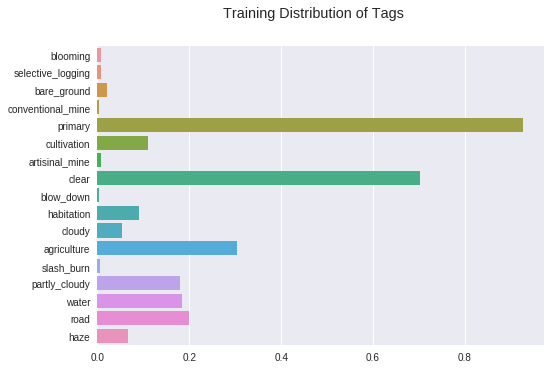

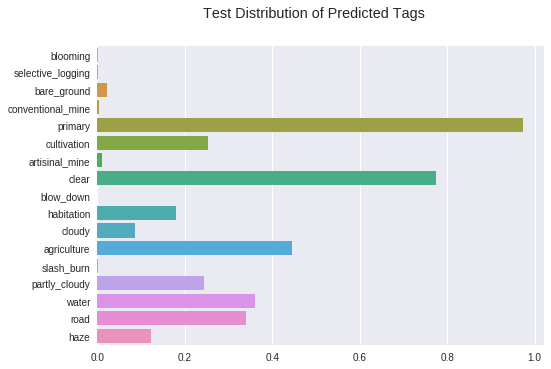

In [16]:
import seaborn as sns

sns.plt.suptitle('Training Distribution of Tags')
sns.barplot(np.sum(y_train, axis=0) / y_train.shape[0], labels)
sns.plt.figure()

sns.plt.suptitle('Test Distribution of Predicted Tags')
sns.barplot(np.sum(np.concatenate([thresh_preds_orig, thresh_preds_add]), axis=0)
            / (thresh_preds_orig.shape[0] + thresh_preds_add.shape[0]), labels)
sns.plt.show()